# Method: RC 
# Dataset: Lorenz-96, F = 8
# Purpose: Uncertainty Quantification - Deep Ensemble

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import sparse

import jax
import jax.numpy as jnp
from jax import value_and_grad
from jax.numpy import tanh
from jax.example_libraries import optimizers

In [3]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [4]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 40)
Test size: (90000, 40)


**Create test set**

In [5]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [6]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [7]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. RC Implementation

In [8]:
def get_parameters(nn_size, connectivity, spec_radius, lambd, 
                   seed, batch_size, num_epoch, lr_schedule = [1e-4], 
                   early_stopping = EARLY_STOPPING):
    """
    Returns trained parameters (beta, intercept) and hidden layer values
    """
    def initialize_coef():
        """
        Initializes W_in and W. 
        W_in size = nn_size x data_dim
        W size = nn_size x nn_size
        """
        start = time()

        # Generate input -> hidden unit weights
        W_in = 2 * (np.random.rand(nn_size, data_dim) - 0.5) 
        W_in = W_in / (4 * np.sqrt(data_dim))

        # Generate hidden -> hidden unit weights
        # Considers connectivity to make the matrix sparse
        start_mat = time()
        rows = np.concatenate([np.full(connectivity, i) for i in range(nn_size)])
        cols = np.concatenate([np.random.choice(range(nn_size), size = connectivity, replace = False) for _ in range(nn_size)])
        vals = np.random.uniform(low = -omega, high = omega, size = (nn_size * connectivity))
        W = sparse.csr_matrix((vals, (rows, cols)), shape = (nn_size, nn_size))
        end_mat = time()
        print(f"W generated. Time taken: {end_mat - start_mat:.2f}s")

        # Calculate eigenvalues for scaling of matrix
        print("Calculating eigenvalue")
        e_start = time()
        eigenvals = sparse.linalg.eigs(W, which = "LM", return_eigenvectors = False, k = 1)
        max_eigen = np.abs(eigenvals)
        e_end = time()
        print(f"Eigenvalue calculated. Time taken: {e_end - e_start:.2f}s")

        # Scale matrix by spectral radius
        W = W / max_eigen * spec_radius # scale the matrix W by its spectral radius
        W = sparse.csr_matrix(W)
        
        end = time()
        print(f"W and W_in generated. Time taken: {end-start:.2f}s")
        print()
        
        return W_in, W
    
    def generate_hidden_states(W_in, W):
        """ 
        Generate hidden states (z) values
        hidden_states size = data_size x nn_size 
        """
        start = time()
        
        print("Generating z values...")
        indiv_z = np.zeros(shape = nn_size)
        hidden_states = np.zeros((train_size, nn_size))
        
        for t in range(train_size):  
            indiv_z = (1 - alpha) * indiv_z + \
                alpha * np.tanh(W_in @ x[t] + W @ indiv_z)
            hidden_states[t, :] = indiv_z
        end = time()
        print(f"z values generated. Time taken: {end-start:.2f}s")
        
        return hidden_states
    
    def mse(y, y_pred):
        return jnp.mean((y_pred - y)**2)
    
    @jax.jit
    def mse_loss(params, x, y):
        """
        returns mean squared error with ridge penalty
        """
        beta, intercept = params
        pred = x @ beta + intercept
        return mse(pred, y) + np.mean(beta**2) * lambd / 2 + np.mean(intercept**2) * lambd / 2
    
    def validation_loss(params, x_val, y_val):
        beta, intercept = params
        num_data_test, trans, data_dim = x_val.shape # testing ex, # steps used (transient), dim of data

        def prediction(inp):
            """
            Returns the mean of one of the testing input

            mean will be a length_to_test x data_dim vector
            """
            z = np.zeros((nn_size // 2, ))
            for i in range(trans):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)

            mus = []
            stddevs = []

            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
            mus.append(x)

            for _ in range(L_forecast_test - 1):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
                x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
                mus.append(x)

            return mus

        mean_list = []
        sd_list = []

        for i in range(num_data_test):
            pred = prediction(x_val[i])
            mean_list.append(pred)

        return mse(mean_list, y_val)

    def training(x, y):
        """ 
        Trains regression of y~x using SGD. 
        Returns parameters (beta, intercept) where 
        beta, intercept -> weights to determine the mean
        
        beta size = nn_size x data_dim
        intercept = data_dim (will be added for each training data)
        
        should predict a mu with train_size x data_dim (\mu per dimension per datapoint)
        and a sigma with train_size x 1 (single \sigma for all dimensions per datapoint)
        """
        
        @jax.jit
        def step(opt_state, x, y):
            params = get_params(opt_state)
            value, g = value_and_grad(mse_loss)(params, x, y)
            opt_state = opt_update(0, g, opt_state)
            return get_params(opt_state), opt_state, value

        start = time()
        
        # Plot loss
        loss_train_traj = []
        loss_train_all_traj = []
        
        # Init parameters
        beta = np.random.normal(0, 1 / np.sqrt(nn_size), size = (nn_size, data_dim))
        intercept = np.random.normal(0, 1 / np.sqrt(nn_size * 2), size = (data_dim, ))
        
        t_size = int(1. * train_size)
        # v_size = train_size - t_size
        # t_start_val = np.linspace(t_size, train_size - (L_forecast_test + 2), NUM_TEST // 2, dtype = int)
        # t_past_batch_val = np.repeat(t_start_val[:, None], WARM_UP_TEST, axis = 1).astype(int) 
        # t_pred_batch_val = (t_start_val[:,None] + np.arange(1,1+L_forecast_test)[None,:]).astype(int) 
        # x_val = copy_x[t_past_batch_val] 
        # y_val = copy_y[t_pred_batch_val]
        
        overall_best_mse = 9999999
        
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init([beta, intercept])
            
            # For early stopping
            best_state = opt_state
            counter = 0 
            best_val_loss = 9999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                T_indices = np.arange(train_size)
                np.random.shuffle(T_indices)

                loss_epoch_train = []
                for k in range(t_size // batch_size + 1):
                    t_start = T_indices[np.arange(k * batch_size, (k+1) * batch_size).astype(int) % len(T_indices)]
                    x_batch = x[t_start]
                    y_batch = y[t_start]

                    params, opt_state, l = step(opt_state, x_batch, y_batch)
                    loss_epoch_train.append(l)
                
                
                loss_train_all_traj += loss_epoch_train
                mse_train = np.mean(loss_epoch_train)
                loss_train_traj.append(mse_train)
                
                e_end = time()
                
                if mse_train < best_val_loss:
                    best_val_loss = mse_train
                    counter = 0
                    best_state = opt_state
                else:
                    counter += 1
                    
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch > 49):
                    print(f"Epoch {epoch + 1}: Train time = {e_end - e_start:.2f} | Train Loss = {mse_train:.7f}", end = " ")
                    
                    # when_to_evaluate = 199 if i == 0 else 49
                    # if epoch >= when_to_evaluate:
                    #     # Validation
                    #     val_start = time()
                    #     mse_val = validation_loss(params, x_val, y_val)
                    #     if best_val_loss > mse_val: # Improvement 
                    #         counter = 0
                    #         best_val_loss = mse_val
                    #         best_state = opt_state
                    #     else:
                    #         counter += 1    
                        # val_end = time()
                        # print(f"| Val time: {val_end - val_start:2f} | Val loss: {mse_val:.7f}", end = "")
                    print()
                if counter == early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f}")
                    break
            
            print(f"Best Training MSE: {best_val_loss:.7f}") 
            
            if best_val_loss < overall_best_mse:
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_val_loss
                overall_best_state = best_state
            
            beta, intercept = get_params(overall_best_state)
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return get_params(overall_best_state) # beta, intercept
    
    start = time()
   
    x, y = train.data[:-1], train.data[1:]
    copy_x, copy_y = x, y 
    train_size, data_dim = x.data.shape
       
    np.random.seed(seed)
    W_in, W = initialize_coef()
    z = generate_hidden_states(W_in, W)

    # Want to regression Y ~ X ==> Y ~ [z, z**2]
    final_y = y[transient:]
    final_z = z[transient:]
    print("Concatenating z with z**2", end = " "); concat_start = time()
    final_z = np.concatenate([final_z, final_z**2], axis = 1) # shape: train_size x (nn_size*2)
    concat_end = time()
    print(f"Contenation complete. Time taken: {concat_end-concat_start:.2f}s", end = "\n\n")
    
    train_size, nn_size = final_z.shape
    
    params = training(final_z, final_y)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return params, (final_z, W_in, W)

In [9]:
def get_test_pred(data_test, nn_size, params, W_in, W):   
    beta, intercept = params
    num_data_test, trans, data_dim = data_test.shape # testing ex, # steps used (transient), dim of data
    
    def prediction(inp):
        """
        Returns the mean of one of the testing input
        
        mean will be a length_to_test x data_dim vector
        """
        
        z = np.zeros((nn_size, ))
        for i in range(trans):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)
        
        mus = []
        stddevs = []
        
        x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
        mus.append(x)
        
        for _ in range(L_forecast_test - 1):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
            mus.append(x)
        
        return mus
    
    start = time()
    
    mean_list = []
    sd_list = []
    
    for i in range(num_data_test):
        pred = prediction(data_test[i])
        mean_list.append(pred)

        if (i+1) % 10 == 0:
            print(f"{(i+1) / num_data_test * 100:.2f}% done")
    
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mean_list)

# 3. Best Parameters

In [10]:
nn_size = 12000
ridge_penalty = 1e-6
spec_radius = 0.1
connectivity = 4

lr_list = [1e-4]
epoch_list = [300]

transient = 200  # points to ignore to allow system to stabilise
omega = 1         # scale of the values of matrix W
alpha = 1         # hidden state memory
b_size = 200

# 4. Ensemble

In [10]:
res_folder = os.path.join("results", "ensemble")

In [16]:
def run_seed(seed):
    """
    Runs the experiment with optimal parameters and saves the predictions into a file
    """
    params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = seed, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)
    _, W_in, W = internal
    mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)
    file_name = "mu_preds_" + str(seed) + ".pkl"
    save_obj(mean_pred, res_folder, file_name)

## 4.1 Seed 2

In [12]:
run_seed(2)

W generated. Time taken: 28.40s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 3.91s
W and W_in generated. Time taken: 36.03s

Generating z values...
z values generated. Time taken: 58.19s
Concatenating z with z**2 Contenation complete. Time taken: 14.07s

Epoch 10: Train time = 10.46 | Train Loss = 0.0000118 
Epoch 20: Train time = 9.73 | Train Loss = 0.0000126 
Epoch 30: Train time = 10.38 | Train Loss = 0.0000117 
Epoch 40: Train time = 10.35 | Train Loss = 0.0000108 
Epoch 50: Train time = 10.35 | Train Loss = 0.0000100 
Epoch 51: Train time = 10.43 | Train Loss = 0.0000098 
Epoch 53: Train time = 10.45 | Train Loss = 0.0000097 
Epoch 54: Train time = 10.43 | Train Loss = 0.0000096 
Epoch 55: Train time = 10.39 | Train Loss = 0.0000095 
Epoch 57: Train time = 10.00 | Train Loss = 0.0000094 
Epoch 59: Train time = 10.32 | Train Loss = 0.0000093 
Epoch 60: Train time = 9.91 | Train Loss = 0.0000091 
Epoch 63: Train time = 10.31 | Train Loss = 0.0000090 
Epoch 64: Train tim

## 4.2 Seed 4

In [13]:
run_seed(4)

W generated. Time taken: 21.91s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 10.11s
W and W_in generated. Time taken: 35.21s

Generating z values...
z values generated. Time taken: 55.08s
Concatenating z with z**2 Contenation complete. Time taken: 12.23s

Epoch 10: Train time = 11.47 | Train Loss = 0.0000118 
Epoch 20: Train time = 11.33 | Train Loss = 0.0000125 
Epoch 30: Train time = 11.53 | Train Loss = 0.0000117 
Epoch 40: Train time = 11.51 | Train Loss = 0.0000108 
Epoch 50: Train time = 11.29 | Train Loss = 0.0000098 
Epoch 51: Train time = 11.41 | Train Loss = 0.0000098 
Epoch 52: Train time = 11.40 | Train Loss = 0.0000097 
Epoch 54: Train time = 11.31 | Train Loss = 0.0000096 
Epoch 55: Train time = 11.41 | Train Loss = 0.0000096 
Epoch 56: Train time = 11.50 | Train Loss = 0.0000095 
Epoch 57: Train time = 11.44 | Train Loss = 0.0000095 
Epoch 58: Train time = 11.30 | Train Loss = 0.0000093 
Epoch 59: Train time = 11.40 | Train Loss = 0.0000092 
Epoch 60: Train 

## 4.3 Seed 6

In [14]:
run_seed(6)

W generated. Time taken: 20.61s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 0.89s
W and W_in generated. Time taken: 24.54s

Generating z values...
z values generated. Time taken: 44.75s
Concatenating z with z**2 Contenation complete. Time taken: 10.31s

Epoch 10: Train time = 10.32 | Train Loss = 0.0000121 
Epoch 20: Train time = 10.32 | Train Loss = 0.0000125 
Epoch 30: Train time = 11.51 | Train Loss = 0.0000116 
Epoch 40: Train time = 11.33 | Train Loss = 0.0000107 
Epoch 50: Train time = 11.38 | Train Loss = 0.0000099 
Epoch 51: Train time = 11.39 | Train Loss = 0.0000098 
Epoch 53: Train time = 11.39 | Train Loss = 0.0000097 
Epoch 54: Train time = 11.41 | Train Loss = 0.0000095 
Epoch 55: Train time = 11.35 | Train Loss = 0.0000095 
Epoch 56: Train time = 11.25 | Train Loss = 0.0000094 
Epoch 57: Train time = 11.40 | Train Loss = 0.0000093 
Epoch 58: Train time = 11.23 | Train Loss = 0.0000093 
Epoch 59: Train time = 11.34 | Train Loss = 0.0000093 
Epoch 60: Train t

## 4.4 Seed 8

In [12]:
run_seed(8)

W generated. Time taken: 20.28s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 3.46s
W and W_in generated. Time taken: 26.74s

Generating z values...
z values generated. Time taken: 43.49s
Concatenating z with z**2 Contenation complete. Time taken: 11.24s

Epoch 10: Train time = 10.67 | Train Loss = 0.0000117 
Epoch 20: Train time = 10.80 | Train Loss = 0.0000125 
Epoch 30: Train time = 11.16 | Train Loss = 0.0000117 
Epoch 40: Train time = 11.51 | Train Loss = 0.0000107 
Epoch 50: Train time = 11.74 | Train Loss = 0.0000099 
Epoch 51: Train time = 12.46 | Train Loss = 0.0000098 
Epoch 52: Train time = 11.41 | Train Loss = 0.0000097 
Epoch 54: Train time = 11.43 | Train Loss = 0.0000095 
Epoch 55: Train time = 13.11 | Train Loss = 0.0000095 
Epoch 56: Train time = 11.96 | Train Loss = 0.0000095 
Epoch 57: Train time = 12.17 | Train Loss = 0.0000094 
Epoch 58: Train time = 11.42 | Train Loss = 0.0000093 
Epoch 59: Train time = 11.81 | Train Loss = 0.0000092 
Epoch 60: Train t

## 4.5 Seed 42
Done in original prediction

In [21]:
run_seed(42)

W generated. Time taken: 23.49s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.70s
W and W_in generated. Time taken: 29.42s

Generating z values...
z values generated. Time taken: 51.86s
Concatenating z with z**2 Contenation complete. Time taken: 157.77s

Epoch 10: Train time = 16.58 | Train Loss = 0.0000119 
Epoch 20: Train time = 15.82 | Train Loss = 0.0000125 
Epoch 30: Train time = 14.82 | Train Loss = 0.0000117 
Epoch 40: Train time = 16.09 | Train Loss = 0.0000107 
Epoch 50: Train time = 14.65 | Train Loss = 0.0000099 
Epoch 51: Train time = 16.30 | Train Loss = 0.0000098 
Epoch 52: Train time = 14.97 | Train Loss = 0.0000098 
Epoch 53: Train time = 16.32 | Train Loss = 0.0000097 
Epoch 54: Train time = 14.93 | Train Loss = 0.0000095 
Epoch 55: Train time = 15.66 | Train Loss = 0.0000094 
Epoch 57: Train time = 14.37 | Train Loss = 0.0000094 
Epoch 58: Train time = 13.40 | Train Loss = 0.0000093 
Epoch 59: Train time = 12.19 | Train Loss = 0.0000092 
Epoch 60: Train 

## 4.6 Compilation of means

In [11]:
mu_preds = []

In [12]:
for dirpath, dirnames, filenames in os.walk(res_folder):
    for f in filenames:
        mu_preds.append(load_obj(os.path.join(res_folder, f)))

In [13]:
mu_preds = np.array(mu_preds)

In [14]:
print(f"mean preds shape: {mu_preds.shape}")

mean preds shape: (5, 100, 400, 40)


# 5. Analyze results

## 5.1 MSE

In [15]:
mixture_pred_all_mean = mu_preds.mean(axis = 0)

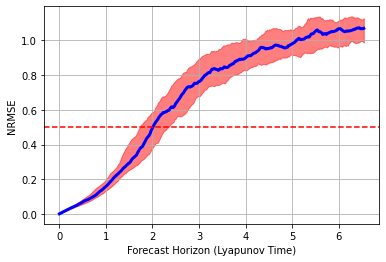

It takes around 2.02 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.069
Median NRMSE at 1.0 Lyapunov Time: 0.159
Median NRMSE at 2.0 Lyapunov Time: 0.497
Median NRMSE at 5.0 Lyapunov Time: 0.977


In [16]:
res_single = PointExperimentResultLyapunov(mixture_pred_all_mean - y_test, "lorenz")
res_single.plot_rmse(save_name = "RC Deep Ensemble Horizon")
print()
res_single.get_loss()

## 5.2 Variance

**Visualise for one dataset**

In [17]:
idx = 0

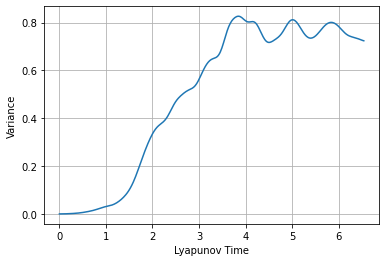

In [18]:
plt.plot(np.arange(L_forecast_test) / LORENZ_LT * 0.01, mu_preds.var(axis = 0)[idx].mean(axis = 1))
plt.grid("on")
plt.xlabel("Lyapunov Time")
plt.ylabel("Variance")
plt.savefig("RC Deep Ensemble Variance.png", facecolor = "white", bbox_inches = "tight")
plt.show()

## 5.3 Negative Log LH

In [16]:
def neg_log_LH(mean_pred, sd_pred):
    d = 40
    
    constant_loss = d * np.log(2 * np.pi)
    mu_loss = (mean_pred - y_test)**2
    
    return 0.5 * (constant_loss + d * np.log(sd_pred) + (mu_loss / sd_pred**2)).mean(axis = (0, 2))

In [17]:
std_dev = mu_preds.std(axis = 0)

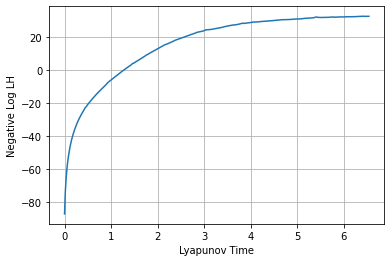

In [18]:
plt.plot(np.arange(L_forecast_test) / LORENZ_LT * 0.01, neg_log_LH(mixture_pred_all_mean,  std_dev))
# plt.title("Negative Log LH against time")
plt.ylabel("Negative Log LH")
plt.xlabel("Lyapunov Time")
plt.grid("on")
plt.savefig("RC Deep Ensemble NLL.png", facecolor = "white", bbox_inches = "tight")
plt.show()

In [19]:
print(f"Overall negative log LH: {neg_log_LH(mixture_pred_all_mean, std_dev).mean():.5f}")

Overall negative log LH: 15.86700
